# Import

In [ ]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import os.path, sys
import numpy as np
import random
import csv

from tensorflow import keras
from tensorflow.keras import layers, datasets, models, optimizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, Activation, MaxPooling2D, Dropout, Flatten, Dense, AveragePooling2D
from tensorflow.keras import  Input
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import tqdm
import zipfile
from sklearn.metrics import confusion_matrix
import itertools

import imutils
import numpy as np
from tensorflow.keras.models import load_model
import numpy as np
import gdown

# check GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


# Download **5 classes** datasets

## PEPE/TEDESCHI dataset

In [ ]:
gdown.download("https://drive.google.com/uc?export=download&id=1QZvZEnovbfbQxxZ3Q-v-LenvHf4RQQ1T", "./train.zip", quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1-125OQ66bsJPHa3chQi7khng1Nx2Hn7E", "./dev.zip", quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1-5Nfa7KamMMvtxwVZGtLi6b1hR8zCh-k", "./test.zip", quiet=False) 

In [ ]:
if os.path.exists("./train.zip"):
    print("Extracting the archive")
    with zipfile.ZipFile('./train.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata/")
    with zipfile.ZipFile('./dev.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata/")
    with zipfile.ZipFile('./test.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata/")
    print("Done")
    os.remove("./train.zip")   
    os.remove("./dev.zip") 
    os.remove("./test.zip")

## BORZILLO/COCCI dataset

In [ ]:
gdown.download("https://drive.google.com/uc?export=download&id=1-ZhhWeN1XLzJNJLJlltJpN9C-sU_d_1l", "./train2.zip", quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1TKxYXXKJH8kc2lNxOX7UGe0KtZr_cvOp", "./dev2.zip", quiet=False) 
gdown.download("https://drive.google.com/uc?export=download&id=1GxMV3H5OP895vYlhWzE87AlkJ4yhPGZJ", "./test2.zip", quiet=False) 

In [ ]:
if os.path.exists("./train2.zip"):
    print("Extracting the archive")
    with zipfile.ZipFile('./train2.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata/train2") 
    with zipfile.ZipFile('./dev2.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata/dev2")
    with zipfile.ZipFile('./test2.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata/test2")
    print("Done")
    os.remove("./train2.zip")   
    os.remove("./dev2.zip") 
    os.remove("./test2.zip")

Final directories in localdata:
* /content/localdata/train
* /content/localdata/train2
* /content/localdata/dev
* /content/localdata/dev2
* /content/localdata/test 
* /content/localdata/test2

In [ ]:
def count_in_unzip():
    print("**** TRAIN ****")
    print()
    directory = "./localdata/train"
    print("PEPE/TEDESCHI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))
    
    print()
    directory = "./localdata/train2"
    print("BORZILLO/COCCI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))

    print("\n")
    print("***** DEV *****")
    print()
    directory = "./localdata/dev"
    print("PEPE/TEDESCHI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))
    
    print()
    directory = "./localdata/dev2"
    print("BORZILLO/COCCI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))

    print("\n")
    print("***** TEST ****")
    print()
    directory = "./localdata/test"
    print("PEPE/TEDESCHI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))
    
    print()
    directory = "./localdata/test2"
    print("BORZILLO/COCCI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))

In [ ]:
count_in_unzip()

**** TRAIN ****

PEPE/TEDESCHI:  ./localdata/train/train
num classes: 5
center: 16473
down: 17841
left: 18014
right: 17251
up: 16959

BORZILLO/COCCI:  ./localdata/train2
num classes: 5
center: 19697
down: 15927
left: 15915
right: 16012
up: 15909


***** DEV *****

PEPE/TEDESCHI:  ./localdata/dev/dev
num classes: 5
center: 2446
down: 2673
left: 2573
right: 2380
up: 2614

BORZILLO/COCCI:  ./localdata/dev2
num classes: 5
center: 3122
down: 3128
left: 3134
right: 3133
up: 3230


***** TEST ****

PEPE/TEDESCHI:  ./localdata/test/test
num classes: 5
center: 3294
down: 3445
left: 3407
right: 3697
up: 3294

BORZILLO/COCCI:  ./localdata/test2
num classes: 5
center: 3867
down: 3035
left: 3112
right: 3121
up: 3059


The directories that contain the training, validation and test data of the BORZILLO/COCCI dataset are called:
- **train2**: **center**, **down**, **left**, **right**, **up** --> TRAINING SET
- **dev2**: **center**, **down**, **left**, **right**, **up** --> VALIDATION SET
- **test2**: **center**, **down**, **left**, **right**, **up** --> TEST SET

The directories that contain the training, validation and test data of the PEPE/TEDESCHI dataset are called:
- **train**: **center**, **down**, **left**, **right**, **up** --> TRAINING SET
- **dev**: **center**, **down**, **left**, **right**, **up** --> VALIDATION SET
- **test**: **center**, **down**, **left**, **right**, **up** --> TEST SET

# Creation of a big merged 5 classes dataset (Pepe/Tedeschi + Cocci/Borzillo)

In [ ]:
class MergedDataset():

  def __init__(self, train_path1, train_path2, val_path1, val_path2, test_path1, test_path2, batch_size, target_size, data_aug, shuffle):

    """
      Args:
        - train: path to the train file
        - test: path to the test file
        - batch: batch size
        - target_size: dimension of images
        - data_aug: boolean that we use for data augmentation
    """

    self.train_file1 = train_path1
    self.train_file2 = train_path2

    self.val_file1 = val_path1
    self.val_file2 = val_path2

    self.test_file1 = test_path1
    self.test_file2 = test_path2

    self.batch_size = batch_size
    self.target_size = target_size
    self.data_aug = data_aug
    self.shuffle = shuffle
    self.train_gen1, self.train_gen2, self.val_gen1, self.val_gen2, self.test_gen1, self.test_gen2, \
    self.train_generator, self.val_generator, self.test_generator = self.create_merged_dataset()
    


  def create_merged_dataset(self):
      """
        creation of the dataset, divided in train, dev and test
      """
      # TRAIN DATA
      if self.data_aug:
          train_data_gen1 = ImageDataGenerator(
              rescale = 1. / 255, # convert from uint8 to float32 in range 0,1
              brightness_range=[0.3,1.5])
          train_data_gen2 = ImageDataGenerator(
              rescale = 1. / 255, # convert from uint8 to float32 in range 0,1
              brightness_range=[0.3,1.5])
      else:
          train_data_gen1 = ImageDataGenerator(rescale = 1. / 255) # convert from uint8 to float32 in range 0,1
          train_data_gen2 = ImageDataGenerator(rescale = 1. / 255) # convert from uint8 to float32 in range 0,1
        

      train_gen1, train_gen2 = self.create_generators(train_data_gen1, train_data_gen2, self.train_file1, self.train_file2, True)
      train_generator = self.merge_generators(train_gen1, train_gen2)

      # VALIDATION DATA
      val_data_gen1 = ImageDataGenerator(rescale = 1. / 255)
      val_data_gen2 = ImageDataGenerator(rescale = 1. / 255)
      
      val_gen1, val_gen2 = self.create_generators(val_data_gen1, val_data_gen2, self.val_file1, self.val_file2, self.shuffle)
      val_generator = self.merge_generators(val_gen1, val_gen2)

      # TEST DATA
      test_data_gen1 = ImageDataGenerator(rescale = 1. / 255)
      test_data_gen2 = ImageDataGenerator(rescale = 1. / 255)

      test_gen1, test_gen2 = self.create_generators(test_data_gen1, test_data_gen2, self.test_file1, self.test_file2, self.shuffle)
      test_generator = self.merge_generators(test_gen1, test_gen2)

      return train_gen1, train_gen2, val_gen1, val_gen2, test_gen1, test_gen2, train_generator, val_generator, test_generator


  def create_generators(self, data_gen1, data_gen2, file1, file2, shuffle):
      generator1 = data_gen1.flow_from_directory(
          directory=file1,
          target_size=self.target_size,
          color_mode="rgb",
          batch_size=self.batch_size,
          class_mode="categorical",
          shuffle=shuffle, 
      )
      generator2 = data_gen2.flow_from_directory(
          directory=file2,
          target_size=self.target_size,
          color_mode="rgb",
          batch_size=self.batch_size,
          class_mode="categorical",
          shuffle=shuffle, 
      )
      return generator1, generator2

  def merge_generators(self, generator1, generator2):
      #try: 
      while True:
        x1, y1 = generator1.next()
        x2, y2 = generator2.next()

        # Concatenate the data from both generators
        x = np.concatenate((x1, x2))
        y = np.concatenate((y1, y2))

        # Create a random permutation of indices
        indices = np.random.permutation(len(x))
        x = x[indices]
        y = y[indices]

        for i in range(0, len(x), self.batch_size):
            yield x[i:i+self.batch_size], y[i:i+self.batch_size]

      #except StopIteration:
        #return

In [ ]:
train_path1 = "/content/localdata/train/"
train_path2 =  "/content/localdata/train2/"
dev_path1 = "/content/localdata/dev/"
dev_path2 =  "/content/localdata/dev2/"
test_path1 = "/content/localdata/test/"
test_path2 =  "/content/localdata/test2/"

data_aug = False
target_size =(128, 128)
batch_size = 64

dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test_path2, batch_size, target_size, data_aug, True)

train_gen1, train_gen2, val_gen1, val_gen2, test_gen1, test_gen2, train_generator, valid_generator, test_generator = dataset.train_gen1, dataset.train_gen2, dataset.val_gen1, dataset.val_gen2, dataset.test_gen1, dataset.test_gen2, dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 86538 images belonging to 5 classes.
Found 83460 images belonging to 5 classes.
Found 12686 images belonging to 5 classes.
Found 15747 images belonging to 5 classes.
Found 17137 images belonging to 5 classes.
Found 16194 images belonging to 5 classes.


In [ ]:
# TRAIN CHECK ..................................................................................................
print("TRAIN DATA: ")
num_samples1 = train_gen1.n
num_samples2 = train_gen2.n
print("Number of samples in Pepe/Tedeschi dataset: ", num_samples1)
print("Number of samples in Borzillo/Cocci dataset: ", num_samples2)
num_samples_train = num_samples1+num_samples2

# check that the number of classes is equal for both merged dataset
num_classes1 = train_gen1.num_classes
num_classes2 = train_gen2.num_classes
assert(num_classes1 == num_classes2)
num_classes = num_classes1

# check that the input shape is equal for both merged dataset
input_shape1 = train_gen1.image_shape
input_shape2 = train_gen2.image_shape
assert(input_shape1 == input_shape2)
input_shape = input_shape1

# check that the class names are equal for both merged dataset
classnames1 = [k for k,v in train_gen1.class_indices.items()]
classnames2 = [k for k,v in train_gen2.class_indices.items()]
assert(classnames1 == classnames2)
classnames = classnames1

print("Classes:\n" , classnames1)
print("\n")
# VAL CHECK ..................................................................................................
print("VALIDATION DATA: ")
num_samples1 = val_gen1.n
num_samples2 = val_gen2.n
print("Number of samples in Pepe/Tedeschi dataset: ", num_samples1)
print("Number of samples in Borzillo/Cocci dataset: ", num_samples2)
num_samples_val = num_samples1+num_samples2

# check that the number of classes is equal for both merged dataset
num_classes1 = val_gen1.num_classes
num_classes2 = val_gen2.num_classes
assert(num_classes1 == num_classes2)

# check that the input shape is equal for both merged dataset
input_shape1 = val_gen1.image_shape
input_shape2 = val_gen2.image_shape
assert(input_shape1 == input_shape2)

# check that the class names are equal for both merged dataset
classnames1 = [k for k,v in val_gen1.class_indices.items()]
classnames2 = [k for k,v in val_gen2.class_indices.items()]
assert(classnames1 == classnames2)

print("Classes:\n" , classnames1)
print("\n")

# TEST CHECK ..................................................................................................
print("TEST DATA: ")
num_samples1 = test_gen1.n
num_samples2 = test_gen2.n
print("Number of samples in Pepe/Tedeschi dataset: ", num_samples1)
print("Number of samples in Borzillo/Cocci dataset: ", num_samples2)
num_samples_test = num_samples1+num_samples2

# check that the number of classes is equal for both merged dataset
num_classes1 = test_gen1.num_classes
num_classes2 = test_gen2.num_classes
assert(num_classes1 == num_classes2)

# check that the input shape is equal for both merged dataset
input_shape1 = test_gen1.image_shape
input_shape2 = test_gen2.image_shape
assert(input_shape1 == input_shape2)

# check that the class names are equal for both merged dataset
classnames1 = [k for k,v in test_gen1.class_indices.items()]
classnames2 = [k for k,v in test_gen2.class_indices.items()]
assert(classnames1 == classnames2)

print("Classes:\n" , classnames1)

TRAIN DATA: 
Number of samples in Pepe/Tedeschi dataset:  86538
Number of samples in Borzillo/Cocci dataset:  83460
Classes:
 ['center', 'down', 'left', 'right', 'up']


VALIDATION DATA: 
Number of samples in Pepe/Tedeschi dataset:  12686
Number of samples in Borzillo/Cocci dataset:  15747
Classes:
 ['center', 'down', 'left', 'right', 'up']


TEST DATA: 
Number of samples in Pepe/Tedeschi dataset:  17137
Number of samples in Borzillo/Cocci dataset:  16194
Classes:
 ['center', 'down', 'left', 'right', 'up']


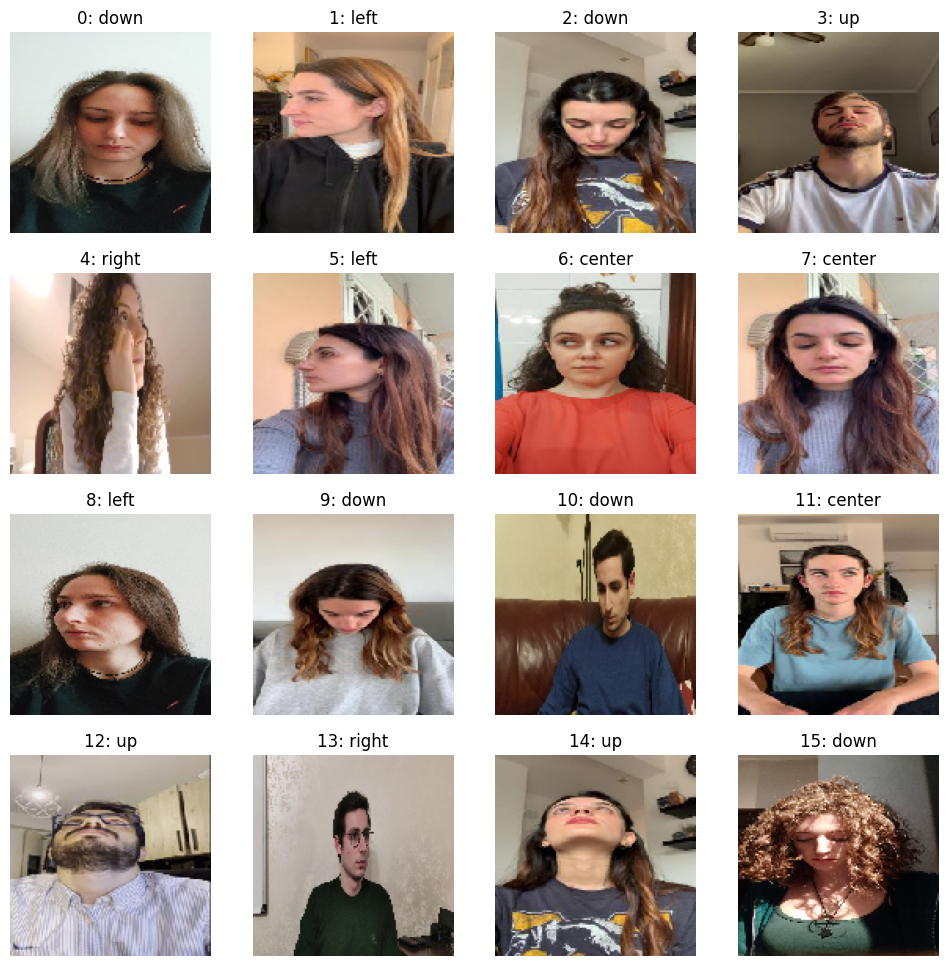

In [ ]:
def show_batch(image_batch, label_batch):

  """
    Args:
      - image_batch: batch of images (not labels)
      - label_batch: batch of labels 
  """
  
  plt.figure(figsize=(12,12))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      idx = np.where(label_batch[n] == 1)[0][0]
      plt.title(str(n) + ": " + classnames1[idx])
      plt.axis('off')

image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

# TASK 1: Attention detection based on facial orientation with COMPLETE dataset

## Model

In [ ]:
class HParams():
  def __init__(self, input_shape, num_classes, lr, model_name, brightness, shift):

    """
      Args:
        - input_shape: shape of images
        - num_classes: number of classes
        - lr: learning rate
        - model_name: name of model
    """
    self.brightness = brightness
    self.shift = shift
    self.shape = input_shape
    self.num_classes = num_classes
    self.lr = lr
    self.optimizer = optimizers.Adam(self.lr)
    self.loss_fn = 'categorical_crossentropy'
    self.metrics = ['accuracy']
    self.drop_rate = 0.5
    self.n_res_net_blocks = 3
    self.n_paths = 4
    self.model_name = model_name #allowed values: Xception, ResNet, ResNeXt, VGG16, VGG19

params = HParams(input_shape, num_classes, 0.00001, "VGG16", True, False)

In [ ]:
class PretrainedModel():
  def __init__(self,name, trainable):

    """
      Args:
        - name: name of pretrained model
        - trainable: boolean used to indicate if layers of pretrained model are freezed or trained
    """
    
    self.name = name
    self.trainable = trainable
    self.model = self.build_model()
  
  def build_model(self):

    if self.name == "Xception":
      base_model = keras.applications.Xception(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )
    elif self.name == "ResNet":
      base_model = keras.applications.ResNet152V2(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )
    elif self.name == "VGG16":
      base_model = keras.applications.VGG16(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )
    else:
      base_model = keras.applications.VGG19(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )

    base_model.trainable = self.trainable
    inputs = keras.Input(shape=input_shape)

    # We freeze pretrained model weigths
    x = base_model(inputs, training=True)

    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(params.drop_rate)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(params.num_classes, activation="softmax")(x)
    model_5_classes = keras.Model(inputs, outputs, name=params.model_name)
    model_5_classes.compile(loss=params.loss_fn, optimizer=params.optimizer, metrics=params.metrics)

    return model_5_classes

In [ ]:
model_5_classes = PretrainedModel(params.model_name, True).model

58889256/58889256 [==============================] - 0s 0us/step


## Training

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from datetime import datetime
data_aug = False
batch_size = 64
nome_prova = f"{params.model_name}{input_shape}_lr{params.lr}_drop{params.drop_rate}_data_aug_{data_aug}_brightness_{params.brightness}_shift_{params.shift}_FACE_DETECTION_{datetime.now().strftime('%Y%m_%d_%H_%M_%S')}"

model_path = "/content/training_5_classes/checkpoints/"+nome_prova+"/"
logs_path = "/content/training_5_classes/tensorboard_logs/"+nome_prova

if not os.path.exists(model_path):
  os.makedirs(model_path)

if not os.path.exists(logs_path):
  os.makedirs(logs_path)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path+'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=logs_path)
]

history = model_5_classes.fit(train_generator, steps_per_epoch = num_samples_train/batch_size, epochs=3, verbose=1, validation_data=valid_generator, validation_steps= num_samples_val/batch_size, callbacks=my_callbacks)


Epoch 1/3
2656/2656 [==============================] - 3135s 1s/step - loss: 0.0855 - accuracy: 0.9672 - val_loss: 0.7512 - val_accuracy: 0.8351
Epoch 2/3
2656/2656 [==============================] - 3072s 1s/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 1.1198 - val_accuracy: 0.8161
Epoch 3/3
2656/2656 [==============================] - 3063s 1s/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 1.0378 - val_accuracy: 0.8536


## Test

In [ ]:
loss, acc = model_5_classes.evaluate(test_generator, steps = num_samples_test/batch_size, verbose=1)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

520/520 [==============================] - 331s 636ms/step - loss: 0.9181 - accuracy: 0.8623
Test loss: 0.918126
Test accuracy: 0.862268


### Saving all the **test** images classified as "center"...

NB. 

**class_to_index** is a dictionary that maps class names to their corresponding class indices.

 For example, class_to_index = {'center': 0, 'up': 1, 'down': 2, 'right': 3, 'left': 4}

In [ ]:
def saving_center_classified_samples(generator1, generator2, model=model_5_classes):
  class_to_index = {'center': 0, 'up': 1, 'down': 2, 'right': 3, 'left': 4}

  # in order to get class probabilities for training and validation samples
  pred_probs = model.predict(generator1)

  # in order to get the predicted classes for training and validation samples
  pred_classes = np.argmax(pred_probs, axis=1)

  # to get the indices of training and validation samples classified as "center"
  center_indices = np.where(pred_classes == class_to_index['center'])[0]

  center_filenames1 = [generator1.filenames[i] for i in center_indices]

  # in order to get class probabilities for training and validation samples
  pred_probs = model.predict(generator2)

  # in order to get the predicted classes for training and validation samples
  pred_classes = np.argmax(pred_probs, axis=1)

  # to get the indices of training and validation samples classified as "center"
  center_indices = np.where(pred_classes == class_to_index['center'])[0]

  center_filenames2 = [generator2.filenames[i] for i in center_indices]


  return center_filenames1+center_filenames2

In [ ]:
test_center_filenames = saving_center_classified_samples(test_gen1,test_gen2,model_5_classes)

254/254 [==============================] - 30s 120ms/step


### Show batch predict test

In [ ]:
dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test_path2, batch_size, target_size, data_aug, True)

_, _, _, _, _, _, _, _, test_generator = dataset.train_gen1, dataset.train_gen2, dataset.val_gen1, dataset.val_gen2, dataset.test_gen1, dataset.test_gen2, dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 86538 images belonging to 5 classes.
Found 83460 images belonging to 5 classes.
Found 12686 images belonging to 5 classes.
Found 15747 images belonging to 5 classes.
Found 17137 images belonging to 5 classes.
Found 16194 images belonging to 5 classes.


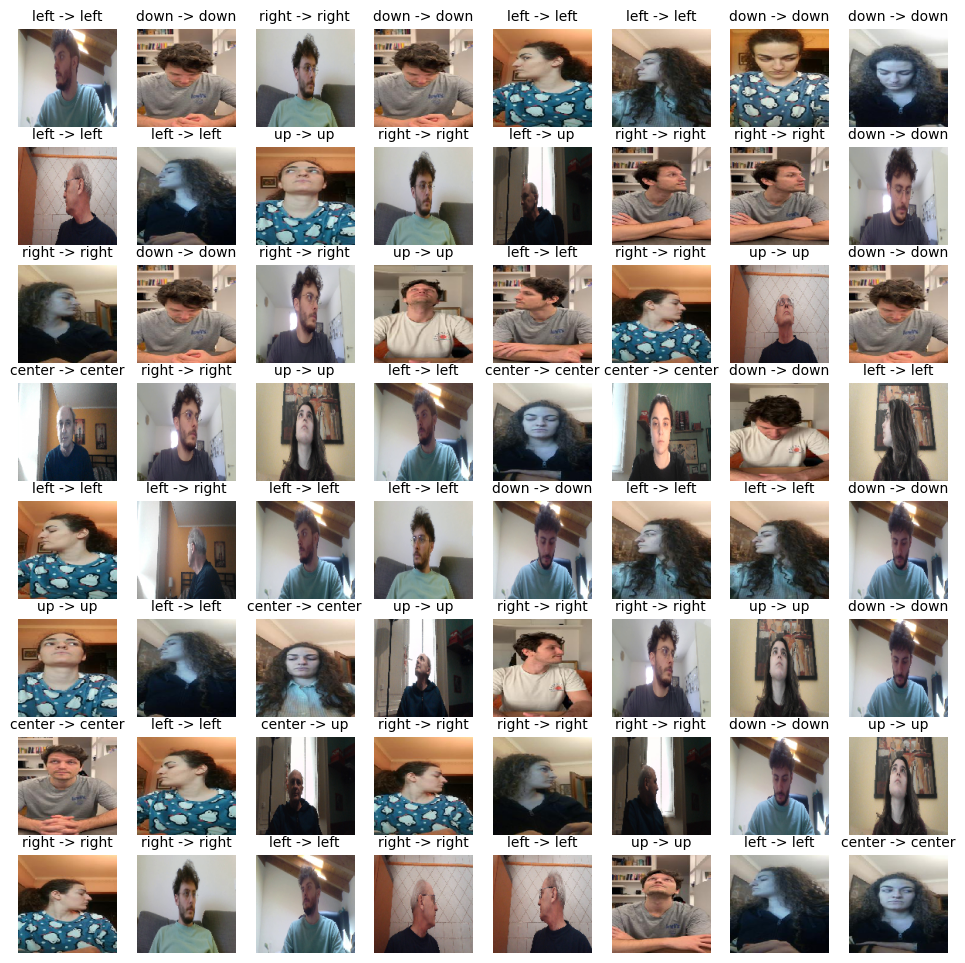

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,12))
  for n in range(64):
      ax = plt.subplot(8,8,n+1)
      plt.imshow(image_batch[n])
      pred = model_5_classes(image_batch)
      idx = np.where(label_batch[n] == 1)[0][0]
      idx_pred = pred[n].numpy().argmax()
      plt.title(f"{classnames[idx]} -> {classnames[idx_pred]}", fontsize=10)
      plt.axis('off')

image_batch, label_batch = next(test_generator)
show_batch(image_batch, label_batch)

### Confusion Matrix plot



In [ ]:
dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test_path2, batch_size, target_size, data_aug, shuffle=False)

_, _, _, _, test_gen1, test_gen2, _, _, test_generator = dataset.train_gen1, dataset.train_gen2, dataset.val_gen1, dataset.val_gen2, dataset.test_gen1, dataset.test_gen2, dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 86538 images belonging to 5 classes.
Found 83460 images belonging to 5 classes.
Found 12686 images belonging to 5 classes.
Found 15747 images belonging to 5 classes.
Found 17137 images belonging to 5 classes.
Found 16194 images belonging to 5 classes.


In [ ]:
predictions1 = model_5_classes.predict(x=test_gen1, steps=len(test_gen1), verbose=1)
predictions2 = model_5_classes.predict(x=test_gen2, steps=len(test_gen2), verbose=1)
predictions = np.concatenate((predictions1,predictions2), axis=0)

254/254 [==============================] - 32s 125ms/step


In [ ]:
test_generator_classes = []
for i in test_gen1.classes:
  test_generator_classes.append(i)
for i in test_gen2.classes:
  test_generator_classes.append(i)
test_generator_classes = np.asarray(test_generator_classes)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

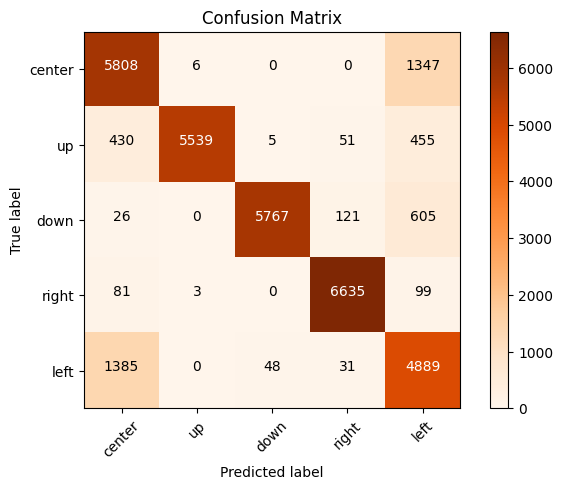

In [ ]:
# vedere se funziona!!! --> train_generator.classes
cm = confusion_matrix(y_true=test_generator_classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['center', 'up', 'down', 'right', 'left']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Taking only "center" classified samples... 

In [ ]:
gdown.download("https://drive.google.com/uc?export=download&id=1E38vwyttfS3f-vNUT5SfH2yfoisw3ns7", "./centers.zip", quiet=False) 

In [ ]:
if os.path.exists("./centers.zip"):
    print("Extracting the archive")
    with zipfile.ZipFile('./centers.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/")
    print("Done")
    os.remove("./centers.zip")

In [ ]:
path_csv = "/content/centers.csv"

In [ ]:
def extract_column_data(file_path, column_index):
    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        column_data = [row[column_index] for row in reader]
    return column_data

imgs_name = extract_column_data(path_csv, 0)
imgs_label = extract_column_data(path_csv, 1)

In [ ]:
def division(center_filenames,folder2_path):
    for ff in center_filenames:
        f = ff.split("/")[1]
        if f in imgs_name:
            label = imgs_label[imgs_name.index(f)]
            final_folder2_path = f"{folder2_path}/{label}/"
            if "frame" in f:
                final_folder_path = f"/content/localdata/test/center/{f}"
            else:
                final_folder_path = f"/content/localdata/test2/center/{f}"
            try:  
                shutil.copy2(final_folder_path, final_folder2_path)
            except:
                pass

In [ ]:
os.mkdir("/content/pipeline_testing")
os.mkdir("/content/pipeline_testing/test")
os.mkdir("/content/pipeline_testing/test/center_0")
os.mkdir("/content/pipeline_testing/test/center_1")

In [ ]:
division(test_center_filenames,"/content/pipeline_testing/test")

In [ ]:
shutil.rmtree("/content/localdata/")

# Download **2 classes** datasets 

## PEPE/TEDESCHI dataset

In [ ]:
gdown.download("https://drive.google.com/uc?export=download&id=1ta-vkLMxCoFfoUx2QIpEVcJX3bKLdFLN", "./train.zip", quiet=False) 
gdown.download("https://drive.google.com/uc?export=donwload&id=1kzCoaslqcZusV0JrEftqk1fM9M5Jgqp-", "./dev.zip", quiet=False) 
gdown.download("https://drive.google.com/uc?export=download&id=1xanRKHH0UrUF9yjW9gkFKudaN8KATlil", "./test.zip", quiet=False) 

In [ ]:
if os.path.exists("./train.zip"):
    print("Extracting the archive")
    with zipfile.ZipFile('./train.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata_2/train/center_1/")
    with zipfile.ZipFile('./dev.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata_2/dev/center_1/")
    with zipfile.ZipFile('./test.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata_2/test/center_1/")
    print("Done")
    os.remove("./train.zip")   
    os.remove("./dev.zip") 
    os.remove("./test.zip")

In [ ]:
os.makedirs("/content/localdata_2/train/center_0", exist_ok=True)
os.makedirs("/content/localdata_2/dev/center_0", exist_ok=True)
os.makedirs("/content/localdata_2/test/center_0", exist_ok=True)

## BORZILLO/COCCI dataset

In [ ]:
gdown.download("https://drive.google.com/uc?export=download&id=1xSl2NM_CryYg27c77EgRSDxXrdQZUpIs", "./train2.zip", quiet=False) 
gdown.download("https://drive.google.com/uc?export=download&id=1TVI1K6D7bjY-7qpUtKGvw8kSxmQzcBtm", "./dev2.zip", quiet=False) 
gdown.download("https://drive.google.com/uc?export=download&id=1eq6XNHrsayylnvNvOREiRsic_M7jWlAZ", "./test2.zip", quiet=False) 

In [ ]:
if os.path.exists("./train2.zip"):
    print("Extracting the archive")
    with zipfile.ZipFile('./train2.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata_2/train2/")
    with zipfile.ZipFile('./dev2.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata_2/dev2/")
    with zipfile.ZipFile('./test2.zip', 'r') as zip_ref:
      zip_ref.extractall("/content/localdata_2/test2/")
    print("Done")
    os.remove("./train2.zip")   
    os.remove("./dev2.zip") 
    os.remove("./test2.zip")

Final directories in localdata:
* /content/localdata/train
* /content/localdata/train2
* /content/localdata/dev
* /content/localdata/dev2
* /content/localdata/test 
* /content/localdata/test2

In [ ]:
def count_in_unzip():
    print("**** TRAIN ****")
    print()
    directory = "./localdata_2/train"
    print("PEPE/TEDESCHI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))
    
    print()
    directory = "./localdata_2/train2"
    print("BORZILLO/COCCI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))

    print("\n")
    print("***** DEV *****")
    print()
    directory = "./localdata_2/dev"
    print("PEPE/TEDESCHI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))
    
    print()
    directory = "./localdata_2/dev2"
    print("BORZILLO/COCCI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))

    print("\n")
    print("***** TEST ****")
    print()
    directory = "./localdata_2/test"
    print("PEPE/TEDESCHI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))
    
    print()
    directory = "./localdata_2/test2"
    print("BORZILLO/COCCI: ", directory)
    l = os.listdir(directory)
    print(f"num classes: {len(l)}")
    l.sort()
    for c in l:
        print(c+": "+str(len(os.listdir(directory+"/"+c))))

In [ ]:
count_in_unzip()

**** TRAIN ****

PEPE/TEDESCHI:  ./localdata_2/train
num classes: 2
center_0: 0
center_1: 16473

BORZILLO/COCCI:  ./localdata_2/train2
num classes: 2
center_0: 16506
center_1: 3191


***** DEV *****

PEPE/TEDESCHI:  ./localdata_2/dev
num classes: 2
center_0: 0
center_1: 2446

BORZILLO/COCCI:  ./localdata_2/dev2
num classes: 2
center_0: 3122
center_1: 0


***** TEST ****

PEPE/TEDESCHI:  ./localdata_2/test
num classes: 2
center_0: 0
center_1: 3294

BORZILLO/COCCI:  ./localdata_2/test2
num classes: 2
center_0: 3119
center_1: 748


# Creation of a big merged 2 classes dataset (Pepe/Tedeschi + Cocci/Borzillo)

In [ ]:
class MergedDataset():

  def __init__(self, train_path1, train_path2, val_path1, val_path2, test_path1, test_path2, batch_size, target_size, data_aug, shuffle):

    """
      Args:
        - train: path to the train file
        - test: path to the test file
        - batch: batch size
        - target_size: dimension of images
        - data_aug: boolean that we use for data augmentation
    """

    self.train_file1 = train_path1
    self.train_file2 = train_path2

    self.val_file1 = val_path1
    self.val_file2 = val_path2

    self.test_file1 = test_path1
    self.test_file2 = test_path2

    self.batch_size = batch_size
    self.target_size = target_size
    self.data_aug = data_aug
    self.shuffle = shuffle
    self.train_gen1, self.train_gen2, self.val_gen1, self.val_gen2, self.test_gen1, self.test_gen2, \
    self.train_generator, self.val_generator, self.test_generator = self.create_merged_dataset()

  def create_merged_dataset(self):
      """
        creation of the dataset, divided in train, dev and test
      """
      # TRAIN DATA
      if self.data_aug:
          train_data_gen1 = ImageDataGenerator(
              rescale = 1. / 255, # convert from uint8 to float32 in range 0,1
              brightness_range=[0.3,1.5])
          train_data_gen2 = ImageDataGenerator(
              rescale = 1. / 255, # convert from uint8 to float32 in range 0,1
              brightness_range=[0.3,1.5])
      else:
          train_data_gen1 = ImageDataGenerator(rescale = 1. / 255) # convert from uint8 to float32 in range 0,1
          train_data_gen2 = ImageDataGenerator(rescale = 1. / 255) # convert from uint8 to float32 in range 0,1
        

      train_gen1, train_gen2 = self.create_generators(train_data_gen1, train_data_gen2, self.train_file1, self.train_file2, shuffle=True)
      train_generator = self.merge_generators(train_gen1, train_gen2)

      # VALIDATION DATA
      val_data_gen1 = ImageDataGenerator(rescale = 1. / 255)
      val_data_gen2 = ImageDataGenerator(rescale = 1. / 255)
      
      val_gen1, val_gen2 = self.create_generators(val_data_gen1, val_data_gen2, self.val_file1, self.val_file2, shuffle=self.shuffle)
      val_generator = self.merge_generators(val_gen1, val_gen2)

      # TEST DATA
      test_data_gen1 = ImageDataGenerator(rescale = 1. / 255)
      test_data_gen2 = ImageDataGenerator(rescale = 1. / 255)

      test_gen1, test_gen2 = self.create_generators(test_data_gen1, test_data_gen2, self.test_file1, self.test_file2, shuffle=self.shuffle)
      test_generator = self.merge_generators(test_gen1, test_gen2)

      return train_gen1, train_gen2, val_gen1, val_gen2, test_gen1, test_gen2, train_generator, val_generator, test_generator


  def create_generators(self, data_gen1, data_gen2, file1, file2, shuffle):
      generator1 = data_gen1.flow_from_directory(
          directory=file1,
          target_size=self.target_size,
          color_mode="rgb",
          batch_size=self.batch_size,
          class_mode="binary",
          shuffle=shuffle, 
      )
      generator2 = data_gen2.flow_from_directory(
          directory=file2,
          target_size=self.target_size,
          color_mode="rgb",
          batch_size=self.batch_size,
          class_mode="binary",
          shuffle=shuffle, 
      )
      return generator1, generator2

  def merge_generators(self, generator1, generator2):
      #try: 
      while True:
        x1, y1 = generator1.next()
        x2, y2 = generator2.next()

        # Concatenate the data from both generators
        x = np.concatenate((x1, x2))
        y = np.concatenate((y1, y2))

        # Create a random permutation of indices
        indices = np.random.permutation(len(x))
        x = x[indices]
        y = y[indices]

        for i in range(0, len(x), self.batch_size):
            yield x[i:i+self.batch_size], y[i:i+self.batch_size]

      #except StopIteration:
        #return

In [ ]:
train_path1 = "/content/localdata_2/train/"
train_path2 =  "/content/localdata_2/train2/"
dev_path1 = "/content/localdata_2/dev/"
dev_path2 =  "/content/localdata_2/dev2/"
test_path1 = "/content/localdata_2/test/"
test_path2 =  "/content/localdata_2/test2/"

data_aug = False
target_size =(128, 128)
batch_size = 64

dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test_path2, batch_size, target_size, data_aug, True)

train_gen1, train_gen2, val_gen1, val_gen2, test_gen1, test_gen2, train_generator, valid_generator, test_generator = dataset.train_gen1, dataset.train_gen2, dataset.val_gen1, dataset.val_gen2, dataset.test_gen1, dataset.test_gen2, dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 16473 images belonging to 2 classes.
Found 19697 images belonging to 2 classes.
Found 2446 images belonging to 2 classes.
Found 3122 images belonging to 2 classes.
Found 3294 images belonging to 2 classes.
Found 3867 images belonging to 2 classes.


In [ ]:
# TRAIN CHECK ..................................................................................................
print("TRAIN DATA: ")
num_samples1 = train_gen1.n
num_samples2 = train_gen2.n
print("Number of samples in Pepe/Tedeschi dataset: ", num_samples1)
print("Number of samples in Borzillo/Cocci dataset: ", num_samples2)
num_samples_train = num_samples1+num_samples2

# check that the number of classes is equal for both merged dataset
num_classes1 = train_gen1.num_classes
num_classes2 = train_gen2.num_classes
assert(num_classes1 == num_classes2)
num_classes = num_classes1

# check that the input shape is equal for both merged dataset
input_shape1 = train_gen1.image_shape
input_shape2 = train_gen2.image_shape
assert(input_shape1 == input_shape2)
input_shape = input_shape1

# check that the class names are equal for both merged dataset
classnames1 = [k for k,v in train_gen1.class_indices.items()]
classnames2 = [k for k,v in train_gen2.class_indices.items()]
assert(classnames1 == classnames2)
classnames = classnames1

print("Classes:\n" , classnames1)
print("\n")
# VAL CHECK ..................................................................................................
print("VALIDATION DATA: ")
num_samples1 = val_gen1.n
num_samples2 = val_gen2.n
print("Number of samples in Pepe/Tedeschi dataset: ", num_samples1)
print("Number of samples in Borzillo/Cocci dataset: ", num_samples2)
num_samples_val = num_samples1+num_samples2

# check that the number of classes is equal for both merged dataset
num_classes1 = val_gen1.num_classes
num_classes2 = val_gen2.num_classes
assert(num_classes1 == num_classes2)

# check that the input shape is equal for both merged dataset
input_shape1 = val_gen1.image_shape
input_shape2 = val_gen2.image_shape
assert(input_shape1 == input_shape2)

# check that the class names are equal for both merged dataset
classnames1 = [k for k,v in val_gen1.class_indices.items()]
classnames2 = [k for k,v in val_gen2.class_indices.items()]
assert(classnames1 == classnames2)

print("Classes:\n" , classnames1)
print("\n")

# TEST CHECK ..................................................................................................
print("TEST DATA: ")
num_samples1 = test_gen1.n
num_samples2 = test_gen2.n
print("Number of samples in Pepe/Tedeschi dataset: ", num_samples1)
print("Number of samples in Borzillo/Cocci dataset: ", num_samples2)
num_samples_test = num_samples1+num_samples2

# check that the number of classes is equal for both merged dataset
num_classes1 = test_gen1.num_classes
num_classes2 = test_gen2.num_classes
assert(num_classes1 == num_classes2)

# check that the input shape is equal for both merged dataset
input_shape1 = test_gen1.image_shape
input_shape2 = test_gen2.image_shape
assert(input_shape1 == input_shape2)

# check that the class names are equal for both merged dataset
classnames1 = [k for k,v in test_gen1.class_indices.items()]
classnames2 = [k for k,v in test_gen2.class_indices.items()]
assert(classnames1 == classnames2)

print("Classes:\n" , classnames1)

TRAIN DATA: 
Number of samples in Pepe/Tedeschi dataset:  16473
Number of samples in Borzillo/Cocci dataset:  19697
Classes:
 ['center_0', 'center_1']


VALIDATION DATA: 
Number of samples in Pepe/Tedeschi dataset:  2446
Number of samples in Borzillo/Cocci dataset:  3122
Classes:
 ['center_0', 'center_1']


TEST DATA: 
Number of samples in Pepe/Tedeschi dataset:  3294
Number of samples in Borzillo/Cocci dataset:  3867
Classes:
 ['center_0', 'center_1']


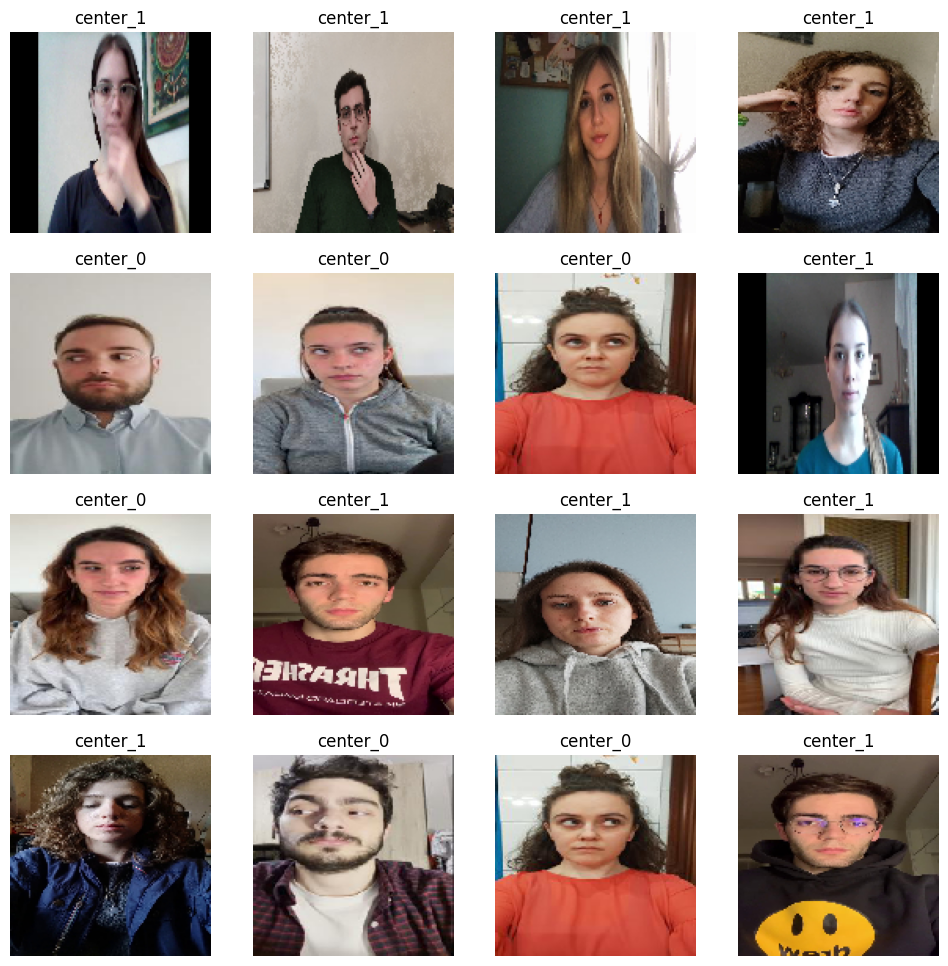

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,12))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      if label_batch[n] == 0:
        plt.title(f"{classnames[0]}")
        plt.axis('off')
      else:
        plt.title(f"{classnames[1]}")
        plt.axis('off')

image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

# TASK 2: Attention detection based on EYE ORIENTATION with COMPLETE dataset



## Model

In [ ]:
class HParams():
  def __init__(self, input_shape, num_classes, lr, model_name, brightness, shift):

    """
      Args:
        - input_shape: shape of images
        - num_classes: number of classes
        - lr: learning rate
        - model_name: name of model
    """
    self.brightness = brightness
    self.shift = shift
    self.shape = input_shape
    self.num_classes = num_classes
    self.lr = lr
    self.optimizer = optimizers.Adam(self.lr)
    self.loss_fn = 'binary_crossentropy'
    self.metrics = ['accuracy']
    self.drop_rate = 0.5
    self.n_res_net_blocks = 3
    self.n_paths = 4
    self.model_name = model_name # allowed values: Xception, ResNet, ResNeXt, VGG16, VGG19

params = HParams(input_shape, num_classes, 0.00001, "VGG16", True, False)

In [ ]:
class PretrainedModel():
  def __init__(self,name, trainable):

    """
      Args:
        - name: name of pretrained model
        - trainable: boolean used to indicate if layers of pretrained model are freezed or trained
    """
    
    self.name = name
    self.trainable = trainable
    self.model = self.build_model()
  
  def build_model(self):

    if self.name == "Xception":
      base_model = keras.applications.Xception(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )
    elif self.name == "ResNet":
      base_model = keras.applications.ResNet152V2(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )
    elif self.name == "VGG16":
      base_model = keras.applications.VGG16(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )
    else:
      base_model = keras.applications.VGG19(
          weights='imagenet',
          input_shape=input_shape,
          include_top=False
      )

    base_model.trainable = self.trainable
    inputs = keras.Input(shape=input_shape)

    # We freeze pretrained model weigths
    x = base_model(inputs, training=True)

    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(params.drop_rate)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model_2_classes = keras.Model(inputs, outputs, name=params.model_name)
    model_2_classes.compile(loss=params.loss_fn, optimizer=params.optimizer, metrics=params.metrics)

    return model_2_classes

In [ ]:
model_2_classes = PretrainedModel(params.model_name, True).model

## Training

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from datetime import datetime

nome_prova = f"{params.model_name}{input_shape}_lr{params.lr}_drop{params.drop_rate}_data_aug_{data_aug}_brightness_{params.brightness}_shift_{params.shift}_FACE_DETECTION_{datetime.now().strftime('%Y%m_%d_%H_%M_%S')}"

model_path = "/content/training_2_classes/checkpoints/"+nome_prova+"/"
logs_path = "/content/training_2_classes/tensorboard_logs/"+nome_prova

if not os.path.exists(model_path):
  os.makedirs(model_path)

if not os.path.exists(logs_path):
  os.makedirs(logs_path)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path+'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=logs_path)
]

history = model_2_classes.fit(train_generator, steps_per_epoch = num_samples_train/batch_size, epochs=3, verbose=1, validation_data=valid_generator, validation_steps= num_samples_val/batch_size, callbacks=my_callbacks)


Epoch 1/3
565/565 [==============================] - 635s 1s/step - loss: 0.0095 - accuracy: 0.9975 - val_loss: 1.0413 - val_accuracy: 0.8916
Epoch 2/3
565/565 [==============================] - 614s 1s/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 1.0718 - val_accuracy: 0.8953
Epoch 3/3
565/565 [==============================] - 628s 1s/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.8952 - val_accuracy: 0.8928


## Test

In [ ]:
loss, acc = model_2_classes.evaluate(test_generator, steps = num_samples_test/batch_size, verbose=1)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

111/111 [==============================] - 69s 618ms/step - loss: 0.4221 - accuracy: 0.8832
Test loss: 0.422071
Test accuracy: 0.883235


## Show batch predict test

In [ ]:
dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test_path2, batch_size, target_size, data_aug, True)
train_gen1, train_gen2, val_gen1, val_gen2, test_gen1, test_gen2, train_generator, valid_generator, test_generator = dataset.train_gen1, dataset.train_gen2, dataset.val_gen1, dataset.val_gen2, dataset.test_gen1, dataset.test_gen2, dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 16473 images belonging to 2 classes.
Found 19697 images belonging to 2 classes.
Found 2446 images belonging to 2 classes.
Found 3122 images belonging to 2 classes.
Found 3294 images belonging to 2 classes.
Found 3867 images belonging to 2 classes.


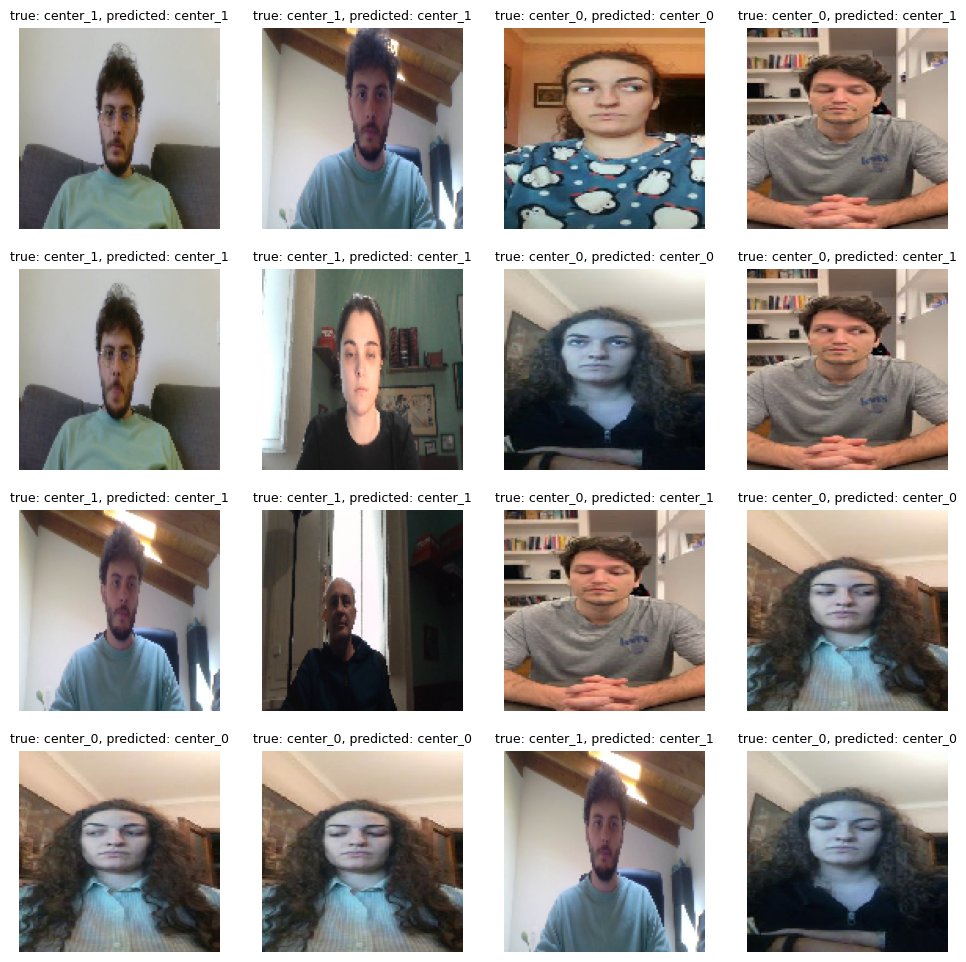

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,12))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      pred = model_2_classes.predict(image_batch, verbose=0)
      #predicted_labels = (1 if pred >= 0.5 else 0)
      predicted_labels = (pred >= 0.5).astype(int)
      idx_pred = predicted_labels[n] # or True or False
      #print(pred, predicted_labels)
      #if idx_pred:
      #  class_pred = 1
      #else: 
      #  class_pred = 0


      if label_batch[n] == 1: 
        plt.title(f"true: {classnames[1]}, predicted: {classnames[int(idx_pred)]}", fontsize=9)
        plt.axis('off')
      else:
        plt.title(f"true: {classnames[0]}, predicted: {classnames[int(idx_pred)]}", fontsize=9)
        plt.axis('off')

image_batch, label_batch = next(test_generator)
show_batch(image_batch, label_batch)

## Confusion Matrix plot

In [ ]:
dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test_path2, batch_size, target_size, data_aug, shuffle=False)

_, _, _, _, test_gen1, test_gen2, _, _, test_generator = dataset.train_gen1, dataset.train_gen2, dataset.val_gen1, dataset.val_gen2, dataset.test_gen1, dataset.test_gen2, dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 16473 images belonging to 2 classes.
Found 19697 images belonging to 2 classes.
Found 2446 images belonging to 2 classes.
Found 3122 images belonging to 2 classes.
Found 3294 images belonging to 2 classes.
Found 3867 images belonging to 2 classes.


In [ ]:
predictions1 = model_2_classes.predict(x=test_gen1, steps=len(test_gen1), verbose=1)
predictions2 = model_2_classes.predict(x=test_gen2, steps=len(test_gen2), verbose=1)
predictions = np.concatenate((predictions1,predictions2), axis=0)

61/61 [==============================] - 9s 153ms/step


In [ ]:
dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test_path2, batch_size, target_size, data_aug, shuffle=False)

_, _, _, _, test_gen1, test_gen2, _, _, test_generator = dataset.train_gen1, dataset.train_gen2, dataset.val_gen1, dataset.val_gen2, dataset.test_gen1, dataset.test_gen2, dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 16473 images belonging to 2 classes.
Found 19697 images belonging to 2 classes.
Found 2446 images belonging to 2 classes.
Found 3122 images belonging to 2 classes.
Found 3294 images belonging to 2 classes.
Found 3867 images belonging to 2 classes.


In [ ]:
test_generator_classes = []
for i in test_gen1.classes:
  test_generator_classes.append(i)
for i in test_gen2.classes:
  test_generator_classes.append(i)
test_generator_classes = np.asarray(test_generator_classes)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Define the custom color map
    #colors = ['orange', 'white']  # Customize the colors here
    #cmap = plt.cm.colors.ListedColormap(colors)
    plt.imshow(cm, cmap=cmap)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        print()
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

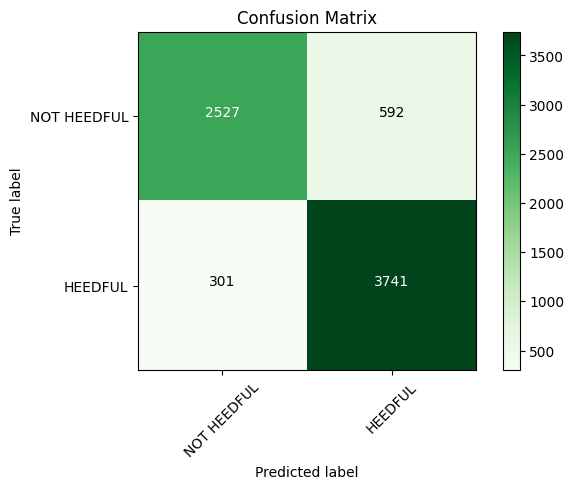

In [ ]:
cm = confusion_matrix(y_true=test_generator_classes, y_pred=(predictions >= 0.5).astype(int))
cm_plot_labels = ['NOT HEEDFUL', 'HEEDFUL']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Pipeline testing...

In [ ]:
data_aug = False
target_size =(128, 128)
batch_size = 64

test2_path = "/content/pipeline_testing/test/"

dataset = MergedDataset(train_path1, train_path2, dev_path1, dev_path2, test_path1, test2_path, batch_size, target_size, data_aug, True)
_, _, test_generator= dataset.train_generator, dataset.val_generator, dataset.test_generator

Found 16473 images belonging to 2 classes.
Found 19697 images belonging to 2 classes.
Found 2446 images belonging to 2 classes.
Found 3122 images belonging to 2 classes.
Found 3294 images belonging to 2 classes.
Found 787 images belonging to 2 classes.


In [ ]:
loss, acc = model_2_classes.evaluate(test_generator, steps=num_samples_test/batch_size, verbose=1)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

111/111 [==============================] - 65s 582ms/step - loss: 0.3768 - accuracy: 0.8887
Test loss: 0.376752
Test accuracy: 0.888715
